In [0]:
import os

data_dir = '/content/drive/My Drive/Colab Notebooks'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [3]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))

for i , line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]

  float_data[i, :] = values

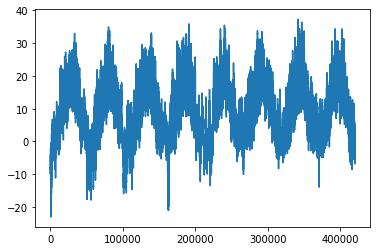

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

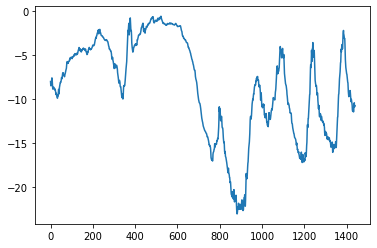

In [6]:
plt.plot(range(1440), temp[:1440])

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /=std

In [9]:
print(float_data.shape)
print(float_data.shape[-1])

(420551, 14)
14


In [0]:
# lookback = 1440 10일 10분 * 6 * 24 * 10
# steps = 6 1시간마다 데이터 포인트
# delay = 144 하루 


# step = 6 이기 때문에 1시간 간격으로 데이터를 추출한다는뜻 
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=6):
  
  if max_index is None:
    # 하루뒤를 예측하는 모델이기 때문에
    # 최대인덱스 = 저장된 로그수 - 하루치 -1 이다 
    max_index = len(data) - delay - 1

  # 최소 인덱스 + 10일뒤가 i 이다 
  i = min_index + lookback

  while 1:
    # 셔플이 필요하면 
    if shuffle:
      # min 과 max 사이의 batch size개의 난수
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      # 최대 인덱스를 넘어가면
      if i + batch_size >= max_index:
        # 인덱스를 초기화 한다.
        i = min_index + lookback

      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    # 빈 행렬을 만들어서 
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows,)))

    # rows 는 인덱스들이 담긴 행렬 (1, 2, 3, 4, 5, 6)
    for j,row in enumerate(rows):
      # j 가 1500이라면 range(60, 1500, 6)
      indices = range(rows[j] - lookback, rows[j], step)

      samples[j] = data[indices]
      # 하루 뒤의 결과물
      targets[j] = data[rows[j] + delay][1]

    yield samples, targets


In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size
                      )

val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size
                    )

test_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 300001,
                    max_index = None,
                    step = step,
                    batch_size = batch_size
                    )


val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size 

In [20]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)

    #오늘의 기온 을 나타낸다.
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  
  print(np.mean(batch_maes))


evaluate_naive_method()

0.2897359729905486


In [0]:
celsius_mae = 0.29 * std[1]

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=( lookback // step, float_data.shape[-1], )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 35ms/step - loss: 1.7027 - val_loss: 0.8742
Epoch 2/20
500/500 [==============================] - 16s 33ms/step - loss: 0.5873 - val_loss: 0.4762
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3143 - val_loss: 0.4010
Epoch 4/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2733 - val_loss: 0.3332
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2593 - val_loss: 0.3396
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2478 - val_loss: 0.3508
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2404 - val_loss: 0.3088
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2333 - val_loss: 0.4565
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2301 - val_loss: 0.3840
Epoch 10/20
500/500 [==============================] - 16s 33ms/step - loss: 0.225

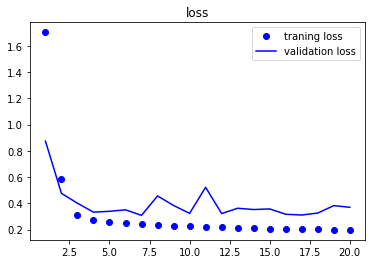

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'bo', label='traning loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('loss')
plt.legend()

plt.show()

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=( None, float_data.shape[-1], )))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 126s 251ms/step - loss: 0.3069 - val_loss: 0.2004
Epoch 2/20
500/500 [==============================] - 127s 254ms/step - loss: 0.2845 - val_loss: 0.2229
Epoch 3/20
500/500 [==============================] - 128s 256ms/step - loss: 0.2768 - val_loss: 0.2294
Epoch 4/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2727 - val_loss: 0.2286
Epoch 5/20
500/500 [==============================] - 133s 266ms/step - loss: 0.2688 - val_loss: 0.2256
Epoch 6/20
500/500 [==============================] - 137s 275ms/step - loss: 0.2631 - val_loss: 0.2324
Epoch 7/20
500/500 [==============================] - 137s 273ms/step - loss: 0.2587 - val_loss: 0.2661
Epoch 8/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2549 - val_loss: 0.2739
Epoch 9/20
500/500 [==============================] - 131s 262ms/step - loss: 0.2511 - val_loss: 0.2749
Epoch 10/20
500/500 [==============================] - 129s 258m

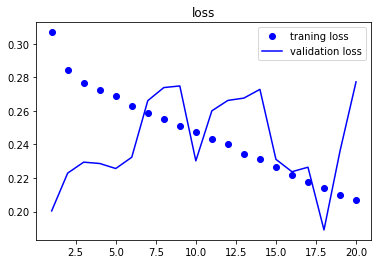

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) +1)

plt.cla()
plt.clf()

plt.plot(epochs, loss, 'bo', label='traning loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('loss')
plt.legend()

plt.show()